In [1]:
%matplotlib inline

from keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from nltk.tokenize import RegexpTokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras import utils
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from collections import Counter
from numpy import array
from numpy import asarray
from numpy import zeros

import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import itertools
import os
import tensorflow as tf
import gensim


import emocoes_texto_classificacao



Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
caminhoDatabase = "C:\\Users\\Deinha\\Documents\\Serpro\\DesafioIA\\PLN\\Codigo\\Dataset\\"

TREINO_PATH = caminhoDatabase + "treino.csv"
TESTE_PATH = caminhoDatabase + "teste-sem-classe.csv"

dfTreino_original = pd.read_csv(TREINO_PATH, sep=",", encoding='utf-8')

#Dados de Teste
dfTeste_original = pd.read_csv(TESTE_PATH, sep=",", encoding='utf-8')

print("Fim do carregamento de dados")

Fim do carregamento de dados


In [110]:
dfTreino = dfTreino_original
dfTeste = dfTeste_original

#padronozação para letras em minúsculo, remoção de stopwords, caracteres especiais, números, espaços e radicais
dfTreino_tratado = emocoes_texto_classificacao.text_preprocess(dfTreino, "classe", "texto", True, 1)
dfTeste_tratado = emocoes_texto_classificacao.text_preprocess(dfTeste, "", "texto", True, 1)


#Inclusão de Campo One Encoding para classificação da rede neural
le = LabelEncoder()
le.fit(dfTreino_tratado["classe"])
print("Classee Enceded", le.classes_)
dfTreino_tratado["classe_enc"] = le.transform(dfTreino_tratado["classe"])


print("=-=-Tratada=-=-")
print(dfTreino_tratado.head(10))

print("=-=-Teste=-=-")
print(dfTeste_tratado.shape)

print("Fim do pré processamento")

Classee Enceded ['alegria' 'desgosto' 'medo' 'neutro' 'raiva' 'surpresa' 'tristeza']
=-=-Tratada=-=-
   id                                              texto    classe  classe_enc
0   0  lul diz sen maior resolv problema presid diz d...    neutro           3
1   1  adolesc mort ouv music alt est unidos adolesc ...  tristeza           6
2   2  core sul insinu hack lig core nort atac intern...    neutro           3
3   3  mama foc sel filhot recem nasc belgica filhot ...   alegria           0
4   4  adolesc ano sum ach mort manaus segund policia...  tristeza           6
5   5  bomb localiz corp jov ano rio mat grosso cas r...  tristeza           6
6   6  medic tent explic orig caibr noturnas episodi ...  surpresa           5
7   7  govern anunc liber bilha agricult familiar val...   alegria           0
8   8  sindicat cuban celebr ano revoluc dia trabalho...    neutro           3
9   9  eclips ajud cient identific assinat planet ter...   alegria           0
=-=-Teste=-=-
(300, 2)
Fim do 

In [4]:
# Método de quebra dos dados
tokenizer = RegexpTokenizer(r'\w+')

# Gerando listas de sentenças quebradas
dfTreino_tratado["tokens"] = dfTreino_tratado["texto"].apply(tokenizer.tokenize)
dfTeste_tratado["tokens"] = dfTeste_tratado["texto"].apply(tokenizer.tokenize)

In [96]:
#Inspecioanndo novamente os dados
all_words = [word for tokens in dfTreino_tratado["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in dfTreino_tratado["tokens"]]

VOCAB = sorted(list(set(all_words)))
caracteres_entrada = max(sentence_lengths)
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))
print("Tamanho máximo de uma caracteres %s" % caracteres_entrada)



32426 Quantidade total de palavras, com um vocabulario de 7374
Tamanho máximo de uma sentença 58
Tamanho máximo de uma caracteres 58


In [6]:
# Construindo bag-of-words com count-vectorizer
count_vectorizer = CountVectorizer()

# Separando o texto da variável alvo
list_corpus = dfTreino_tratado["texto"].tolist()
list_labels = dfTreino_tratado["classe"].tolist()

# Construindo exemplos para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.3, 
                                                                                random_state=40)
# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_counts = count_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_counts = count_vectorizer.transform(X_test)

In [7]:
# Construindo bag-of-words com count-vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Aprendendo o vacabulário e contabilizando os termos para teste
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Contabilizando os termos no vocabulário aprendido para treino
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [12]:
# Aplicando configurações no modelo
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

#Treinando o modelo com o vocabulário construindo e as variáveis alvo
clf.fit(X_train_counts, y_train)

#Realizando as predições para o conjunto de teste
y_predicted_counts = clf.predict(X_test_counts)

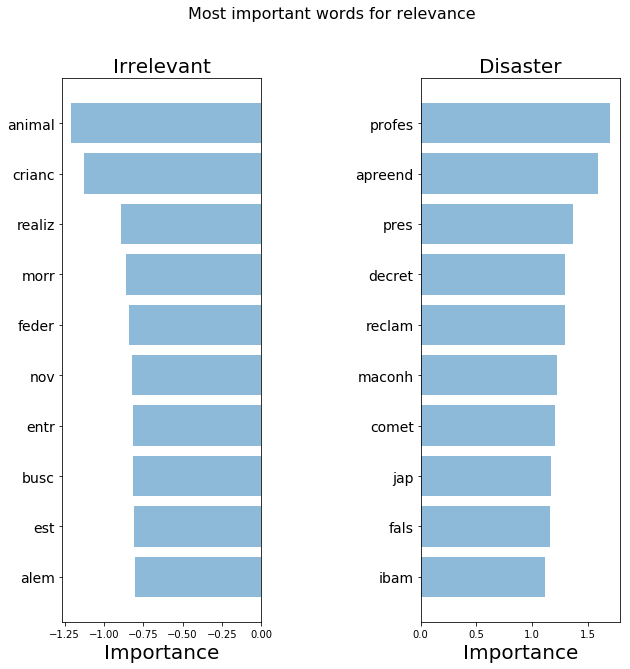

In [16]:
# Método para identificação das features mais importantes na tomada de decisão.
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

# Método para plotar as featrues mais importantes para cada variável alvo.
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")


In [14]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

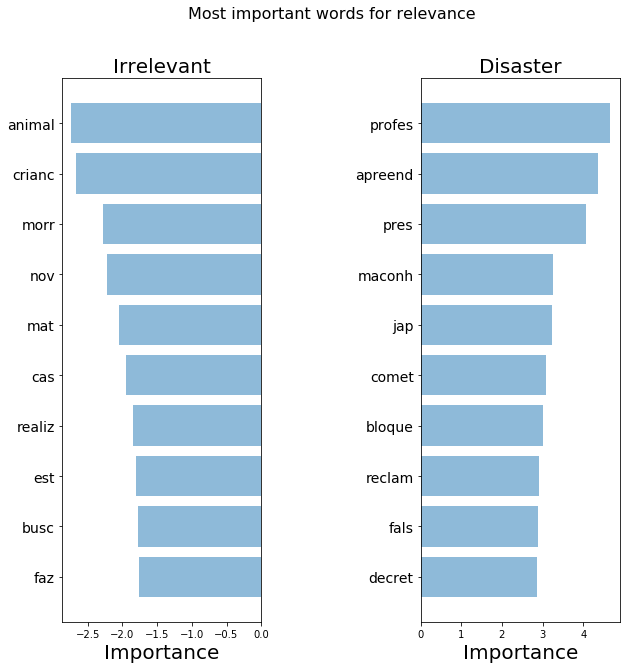

In [17]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [30]:
#Treinando a matriz de relação com notícias do Google
#O conjunto de dados para treinar a matriz pode ser acessado em: 
#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

#word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
#word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

word2vec_path = "C:\\Users\\Deinha\\Documents\\Serpro\\DesafioIA\\PLN\\Codigo\\Dataset\\glove_s300.txt"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path)


In [29]:
#Método para calcular a distância semântica entre as palavras
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

#Montagem do arquivo de treinamento contento a relação semântica entre as palavras
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [31]:
embeddings = get_word2vec_embeddings(word2vec, dfTreino_tratado)

X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

# Deep Learning

Link: https://github.com/pranjalgoel89/Stock-Predictions/blob/aad268201e7101d3a4a03c6e9c6ffd171e4e467a/Sentiment%20analysis%20of%20news/deeplearningModel/Labeling%20News.ipynb

Tutorial Keras: https://machinelearningmastery.com/how-to-make-classification-and-regression-predictions-for-deep-learning-models-in-keras/

In [32]:
dfTreino_tratado = shuffle(dfTreino_tratado)

train_size = int(len(dfTreino_tratado)*.80)
print('Train size:', train_size)


Train size: 1360


In [33]:
#for training the model
train_posts = dfTreino_tratado['texto'][:train_size]
train_tags = dfTreino_tratado['classe_enc'][:train_size]  
train_tags = [round(x,1)  for x in train_tags]

#the model will be trained on 10 labels i.e 0.0 .1 .2 .3 .4 .5 .6 .7 .8 .9 1.0
    
#for testing the trained model....
test_posts = dfTreino_tratado['texto'][train_size:]
test_tags = dfTreino_tratado['classe_enc'][train_size:]
test_tags = [round(x,1)  for x in test_tags]  

print("*****Train Post*****" + "\n")
print(train_posts.head(5), "\n")
print("*****Train Tags*****" + "\n")
print(train_tags, "\n")

print("*****Test Post*****" + "\n")
print(test_posts.head(5), "\n")
print("*****Test Tags*****" + "\n")
print(test_tags, "\n")

*****Train Post*****

1419    cidad escolh nov prefeit ele epoc domingo cida...
390     pres suspeit obrig idos doent ped esmolas goia...
1407    jorn britan destac recif capit assassinat bras...
259     bernardo econom ajud event campanh dilm melhor...
148     profes cort tranc menin veu egito profes menin...
Name: texto, dtype: object 

*****Train Tags*****

[3, 4, 6, 3, 1, 6, 6, 2, 1, 0, 5, 0, 6, 5, 3, 0, 3, 6, 0, 6, 1, 3, 6, 3, 5, 2, 6, 3, 5, 0, 3, 3, 3, 3, 6, 6, 6, 5, 3, 6, 3, 3, 6, 1, 6, 1, 1, 6, 1, 3, 0, 4, 6, 2, 0, 5, 1, 1, 3, 6, 6, 3, 2, 3, 6, 6, 0, 3, 5, 3, 3, 3, 4, 5, 1, 1, 3, 3, 1, 6, 6, 6, 2, 3, 1, 3, 4, 3, 4, 0, 2, 3, 3, 3, 2, 5, 3, 6, 6, 1, 3, 2, 6, 6, 5, 3, 1, 2, 3, 0, 6, 3, 6, 6, 2, 5, 6, 6, 3, 1, 0, 6, 1, 3, 3, 3, 2, 5, 2, 2, 0, 3, 3, 6, 0, 5, 2, 3, 6, 3, 6, 3, 3, 6, 3, 6, 1, 1, 3, 4, 1, 3, 6, 6, 6, 1, 5, 0, 3, 2, 3, 5, 6, 5, 3, 3, 5, 3, 1, 3, 3, 6, 1, 6, 0, 2, 2, 6, 6, 1, 3, 1, 3, 3, 6, 3, 1, 5, 0, 5, 3, 2, 6, 3, 4, 4, 3, 3, 6, 0, 2, 1, 6, 3, 6, 5, 5, 1, 3, 3, 6, 2, 

In [56]:
max_words = 100
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [57]:
tokenize.fit_on_texts(train_posts)
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)


train_tags = [round(x,1)  for x in train_tags]
y_train = train_tags
y_test = test_tags


In [58]:
num_classes = np.max(y_train) + 1
print(num_classes, "\n")
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

7 



In [59]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1360, 100)
x_test shape: (340, 100)
y_train shape: (1360, 7)
y_test shape: (340, 7)


In [60]:
batch_size = 32

In [100]:
### Build the model 1
model = Sequential()

#model.add(Flatten())
model.add(Dense(464,input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256,input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128,input_shape=(max_words,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

history = model.fit(x_train,y_train, batch_size=batch_size, epochs=10, verbose=1, validation_split=0.1)

Train on 1224 samples, validate on 136 samples
Epoch 1/10
1224/1224 [==============================] - 1s 1ms/step - loss: 1.8730 - accuracy: 0.2549 - val_loss: 1.8208 - val_accuracy: 0.4412
Epoch 2/10
1224/1224 [==============================] - 0s 213us/step - loss: 1.7912 - accuracy: 0.3121 - val_loss: 1.7738 - val_accuracy: 0.3750
Epoch 3/10
1224/1224 [==============================] - 0s 230us/step - loss: 1.7372 - accuracy: 0.3415 - val_loss: 1.7051 - val_accuracy: 0.3603
Epoch 4/10
1224/1224 [==============================] - 0s 230us/step - loss: 1.6284 - accuracy: 0.4224 - val_loss: 1.5380 - val_accuracy: 0.4559
Epoch 5/10
1224/1224 [==============================] - 0s 214us/step - loss: 1.4999 - accuracy: 0.4542 - val_loss: 1.5028 - val_accuracy: 0.4559
Epoch 6/10
1224/1224 [==============================] - 0s 229us/step - loss: 1.3948 - accuracy: 0.5139 - val_loss: 1.4769 - val_accuracy: 0.4706
Epoch 7/10
1224/1224 [==============================] - 0s 230us/step - loss: 1

In [101]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

#the accuracy score below is meant for 11 labels if ... we train the model on binary data then 
#this model gives a state of art accuracy of 99%

340/340 [==============================] - 0s 97us/step
Test score: 1.5609444660298966
Test accuracy: 0.4647058844566345


In [102]:
text_labels = le.classes_ 
#output below....
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    #print(test_posts[i])
    #print('Actual label:' + str(test_tags[i]))
    print("Predicted label: " + str(predicted_label) + "\n")

'''
text_labels = le.classes_ 
#output below....
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print("Sentenças:", test_posts[i], "\n")
    print('Actual label:' + str(test_tags[i]), "\n")
    print("Predicted label: " + str(predicted_label) + "\n")
'''

Predicted label: tristeza

Predicted label: tristeza

Predicted label: desgosto

Predicted label: neutro

Predicted label: tristeza

Predicted label: raiva

Predicted label: tristeza

Predicted label: neutro

Predicted label: neutro

Predicted label: neutro



'\ntext_labels = le.classes_ \n#output below....\nfor i in range(10):\n    prediction = model.predict(np.array([x_test[i]]))\n    predicted_label = text_labels[np.argmax(prediction)]\n    print("Sentenças:", test_posts[i], "\n")\n    print(\'Actual label:\' + str(test_tags[i]), "\n")\n    print("Predicted label: " + str(predicted_label) + "\n")\n'

In [103]:
#saving the model so that we do not need to train the model again and again....
model.save('model_file_final.h5')
my_model = load_model('model_file_final.h5')

# Predição das sentenças

In [109]:
dfTexto_tratado = dfTeste_tratado

print("dfTeste_original.head(10): \n", dfTeste_original.head(20))
#print("dfTexto_tratado.shape: \n", dfTexto_tratado.shape)
#print("dfTexto_tratado.head(10): \n", dfTexto_tratado.head(10))

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(dfTexto_tratado["texto"])

x_sentimento = tokenize.texts_to_matrix(dfTexto_tratado["texto"])
#print("x_sentimento.shape: ", x_sentimento.shape)

yPredSentimento = model.predict_classes(x_sentimento)

# show the inputs and predicted outputs
for i in range(len(x_sentimento)):
    print(i,",", le.inverse_transform([yPredSentimento[i]]))

   

dfTeste_original.head(10): 
       id                                              texto
0    270  leopardo faminto se dá mal ao atacar porco-esp...
1    523  general dissidente sai ileso de atentado suici...
2    155  rezem por mim, pede francisco no 1º aniversári...
3   1294  rottweiler participa de trabalho de demolição ...
4   1349  golpe do bilhete premiado leva 4 para a cadeia...
5    236  usp, unicamp e unesp adiam início das aulas po...
6   1691  washington post registra perdas de us$ 19,5 mi...
7    438  parlamento ucraniano aprova criação de força d...
8    677  explosões em bancos assustam municípios no int...
9    422  governo da china promete pulso firme contra co...
10   605  chuva causa estragos em pernambuco e em mato g...
11  1054  motorista de ônibus incendiado que matou crian...
12  1643  henry sobe na carreira de perito três meses ap...
13  1345  criança nasce dentro de carro da polícia milit...
14  1279  lula quer reunião com laboratórios sobre vacin...
15  1017  s